In [4]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [43]:
data = tf.keras.utils.image_dataset_from_directory('new/data')

Found 1500 files belonging to 2 classes.


In [44]:
data_iterator = data.as_numpy_iterator()

In [45]:
batch = data_iterator.next()

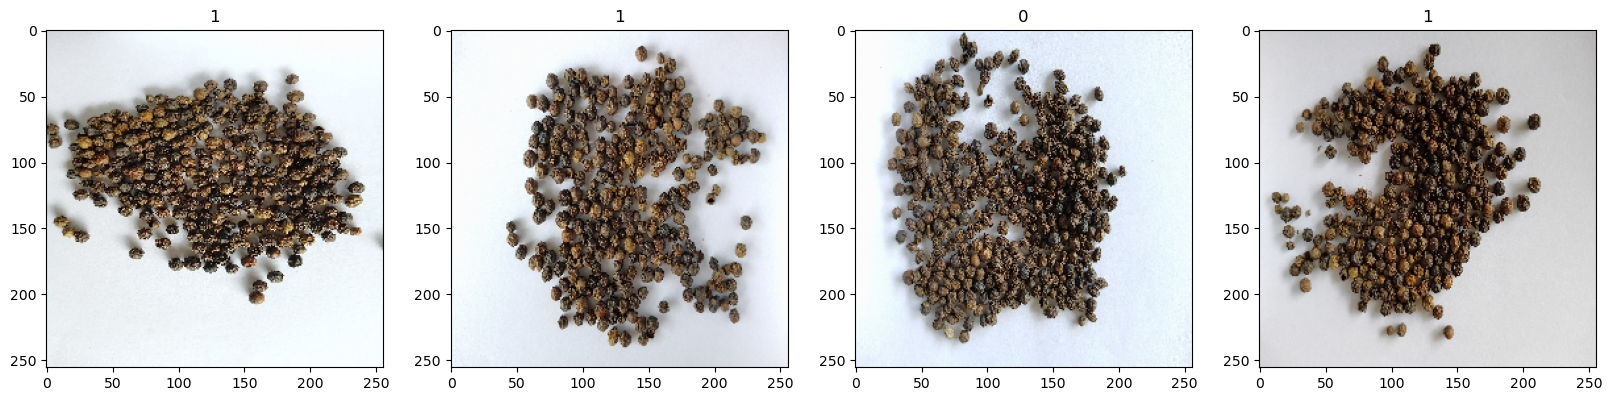

In [46]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [47]:
data = data.map(lambda x, y: (x / 255, y))
data = data.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))

In [48]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.1)
test_size = int(len(data)*.1)

In [49]:
train_size

37

In [50]:
val_size

4

In [51]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [52]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, label

In [53]:
train = train.map(augment_image)

In [54]:
train

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [55]:
model = Sequential()

In [56]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [57]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [58]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [59]:
logdir='logs'

In [60]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [61]:
hist = model.fit(train, epochs=50, validation_data=val, callbacks=[tensorboard_callback, early_stopping])

Epoch 1/50
37/37 [==============================] - 195s 5s/step - loss: 1.1381 - accuracy: 0.6014 - val_loss: 0.6101 - val_accuracy: 0.8203
Epoch 2/50
37/37 [==============================] - 182s 5s/step - loss: 0.6198 - accuracy: 0.7314 - val_loss: 0.4969 - val_accuracy: 0.8516
Epoch 3/50
37/37 [==============================] - 177s 5s/step - loss: 0.5479 - accuracy: 0.7618 - val_loss: 0.4737 - val_accuracy: 0.8438
Epoch 4/50
37/37 [==============================] - 183s 5s/step - loss: 0.4838 - accuracy: 0.8117 - val_loss: 0.3762 - val_accuracy: 0.9062
Epoch 5/50
37/37 [==============================] - 181s 5s/step - loss: 0.4516 - accuracy: 0.8260 - val_loss: 0.4297 - val_accuracy: 0.8906
Epoch 6/50
37/37 [==============================] - 185s 5s/step - loss: 0.3990 - accuracy: 0.8615 - val_loss: 0.3776 - val_accuracy: 0.8906
Epoch 7/50
37/37 [==============================] - 186s 5s/step - loss: 0.4077 - accuracy: 0.8606 - val_loss: 0.3082 - val_accuracy: 0.9219
Epoch 8/50
37

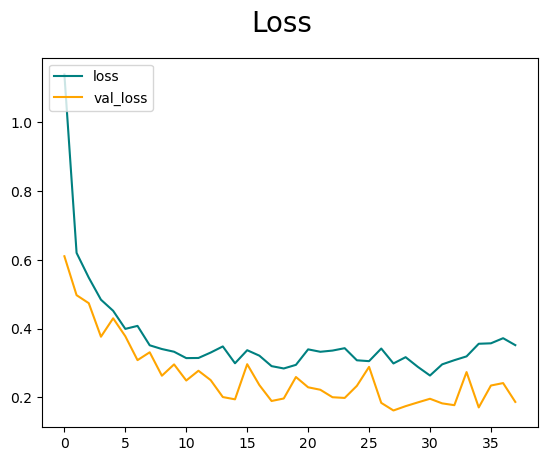

In [62]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

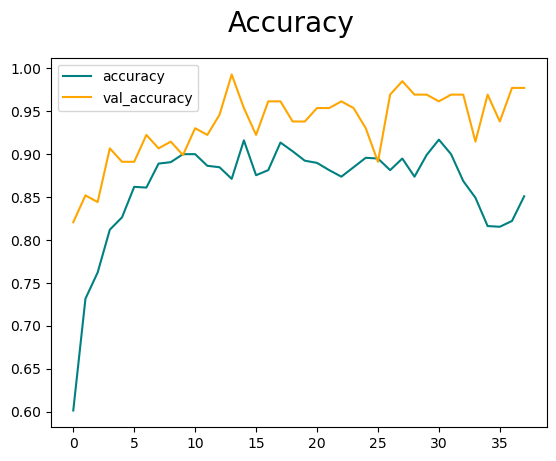

In [63]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [64]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, auc

In [65]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [66]:
true_labels = []
predicted_labels = []

In [67]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    true_labels.extend(y)
    predicted_labels.extend(yhat)

1/1 [==============================] - 3s 3s/step


In [68]:
precision = pre.result().numpy()
recall = re.result().numpy()
accuracy = acc.result().numpy()
f1 = 2 * (precision * recall) / (precision + recall)

In [69]:
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1)

Precision: 1.0
Recall: 0.95384616
Accuracy: 0.9765625
F1 Score: 0.976377924411457


In [70]:
true_labels = np.array(true_labels)
predicted_labels = (np.array(predicted_labels) > 0.5).astype(int)

In [71]:
cm = confusion_matrix(predicted_labels, true_labels)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[63  3]
 [ 0 62]]


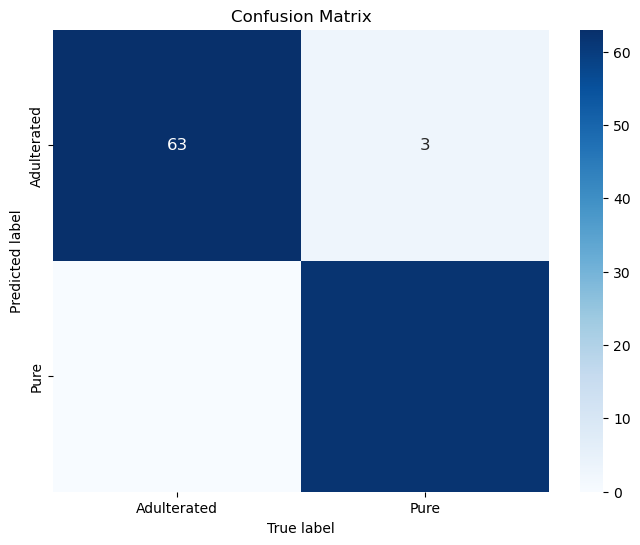

In [72]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Adulterated', 'Pure'], yticklabels=['Adulterated', 'Pure'],
            annot_kws={"fontsize": 12})  # Increase the fontsize
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


In [73]:
report = classification_report(true_labels, predicted_labels, target_names=['Adulterated', 'Pure'], digits=4)
print(report)

              precision    recall  f1-score   support

 Adulterated     0.9545    1.0000    0.9767        63
        Pure     1.0000    0.9538    0.9764        65

    accuracy                         0.9766       128
   macro avg     0.9773    0.9769    0.9766       128
weighted avg     0.9776    0.9766    0.9766       128



Area Under Curve (AUC): 0.9886418269230769


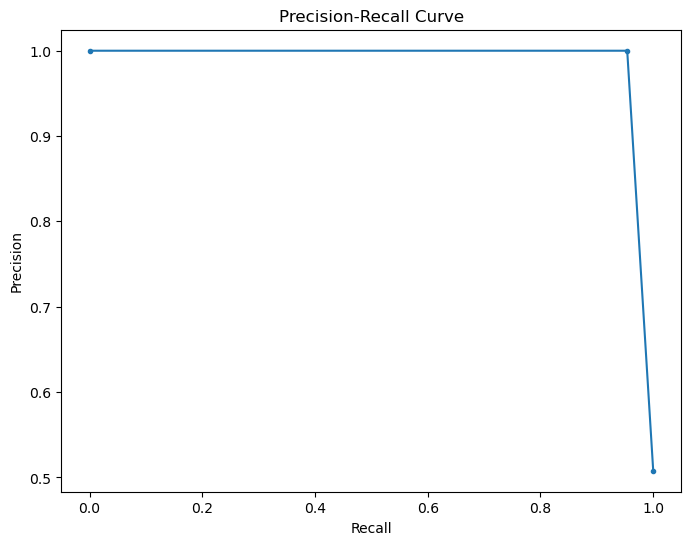

In [74]:
precision, recall, _ = precision_recall_curve(true_labels, predicted_labels)
area_under_curve = auc(recall, precision)

print("Area Under Curve (AUC):", area_under_curve)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

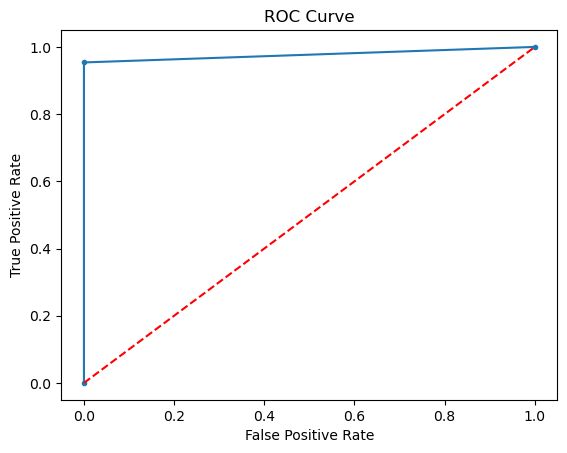

FPR: 0.0, TPR: 0.0
FPR: 0.0, TPR: 0.9538461538461539
FPR: 1.0, TPR: 1.0


In [75]:
from sklearn.metrics import roc_curve
# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Compute ROC curve
fpr, tpr, _ = roc_curve(true_labels, predicted_labels)

# Plot ROC curve
ax.plot(fpr, tpr, marker='.')
ax.plot([0, 1], [0, 1], linestyle='--', color='red')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')

# Show the plot
plt.show()
for i in range(len(fpr)):
    print(f"FPR: {fpr[i]}, TPR: {tpr[i]}")

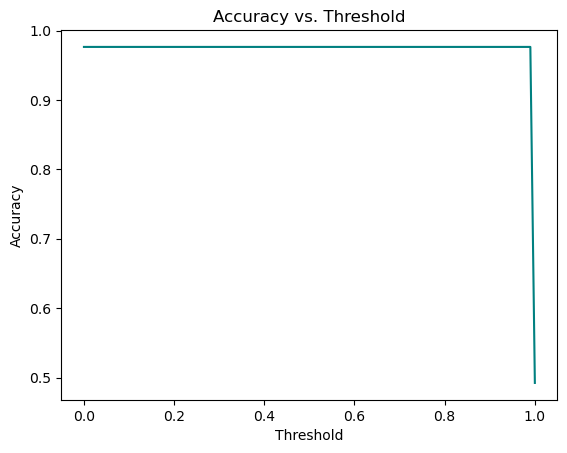

Threshold: 0.00, Accuracy: 0.9766
Threshold: 0.01, Accuracy: 0.9766
Threshold: 0.02, Accuracy: 0.9766
Threshold: 0.03, Accuracy: 0.9766
Threshold: 0.04, Accuracy: 0.9766
Threshold: 0.05, Accuracy: 0.9766
Threshold: 0.06, Accuracy: 0.9766
Threshold: 0.07, Accuracy: 0.9766
Threshold: 0.08, Accuracy: 0.9766
Threshold: 0.09, Accuracy: 0.9766
Threshold: 0.10, Accuracy: 0.9766
Threshold: 0.11, Accuracy: 0.9766
Threshold: 0.12, Accuracy: 0.9766
Threshold: 0.13, Accuracy: 0.9766
Threshold: 0.14, Accuracy: 0.9766
Threshold: 0.15, Accuracy: 0.9766
Threshold: 0.16, Accuracy: 0.9766
Threshold: 0.17, Accuracy: 0.9766
Threshold: 0.18, Accuracy: 0.9766
Threshold: 0.19, Accuracy: 0.9766
Threshold: 0.20, Accuracy: 0.9766
Threshold: 0.21, Accuracy: 0.9766
Threshold: 0.22, Accuracy: 0.9766
Threshold: 0.23, Accuracy: 0.9766
Threshold: 0.24, Accuracy: 0.9766
Threshold: 0.25, Accuracy: 0.9766
Threshold: 0.26, Accuracy: 0.9766
Threshold: 0.27, Accuracy: 0.9766
Threshold: 0.28, Accuracy: 0.9766
Threshold: 0.2

In [76]:
thresholds = np.arange(0, 1.01, 0.01)
predicted_labels = np.array(predicted_labels)
accuracies = [np.mean((predicted_labels.ravel().astype(bool) > threshold) == true_labels) for threshold in thresholds]
plt.plot(thresholds, accuracies, color='teal')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold')
plt.show()
for threshold, accuracy in zip(thresholds, accuracies):
    print(f'Threshold: {threshold:.2f}, Accuracy: {accuracy:.4f}')

In [77]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [78]:
import cv2

1/1 [==============================] - 0s 330ms/step
[[0.03609061]]
Predicted class is Adulterated with confidence level 92.78


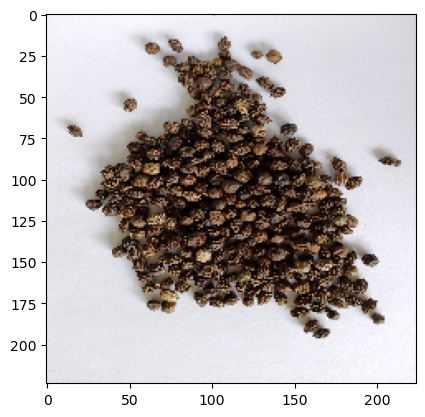

In [79]:
img = cv2.imread('new/Adulterated/A (8).jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
resize = tf.image.resize(img, (224,224))


# Predict the class probabilities
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)

# Get the predicted class and confidence level
threshold = 0.5
predicted_class = 'Pure' if yhat[0] > threshold else 'Adulterated'
confidence_level = (yhat[0][0] - 0.5) * 2 * 100 if yhat[0] > threshold else (0.5 - yhat[0][0]) * 2 * 100
print(f'Predicted class is {predicted_class} with confidence level {confidence_level:.2f}')

plt.imshow(resize.numpy().astype(int))
plt.show()

In [1]:
from tensorflow.keras.models import load_model

In [81]:
model.save(os.path.join('new\models','vgg16.h5'))

C:\Users\rebab\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
loaded_model = load_model('new\models\VGG16.h5')

In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()
with open('new\VGG16.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\rebab\AppData\Local\Temp\tmple32p6rc\assets


INFO:tensorflow:Assets written to: C:\Users\rebab\AppData\Local\Temp\tmple32p6rc\assets
